# Surfs Up! SQLAlchemy Homework Challenge
### Jason Gabunilas

In [1]:
# Import matplotlib
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.dates as mdates

In [2]:
# Import numpy and pandas
import numpy as np
import pandas as pd
import scipy.stats as st

In [3]:
# Import datetime
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model using automap_base
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table.
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Start by examining all of the column names in the Measurement table
inspector = inspect(engine)
columns_meas = inspector.get_columns('measurement')
for column in columns_meas:
    print(column['name'])


id
station
date
prcp
tobs


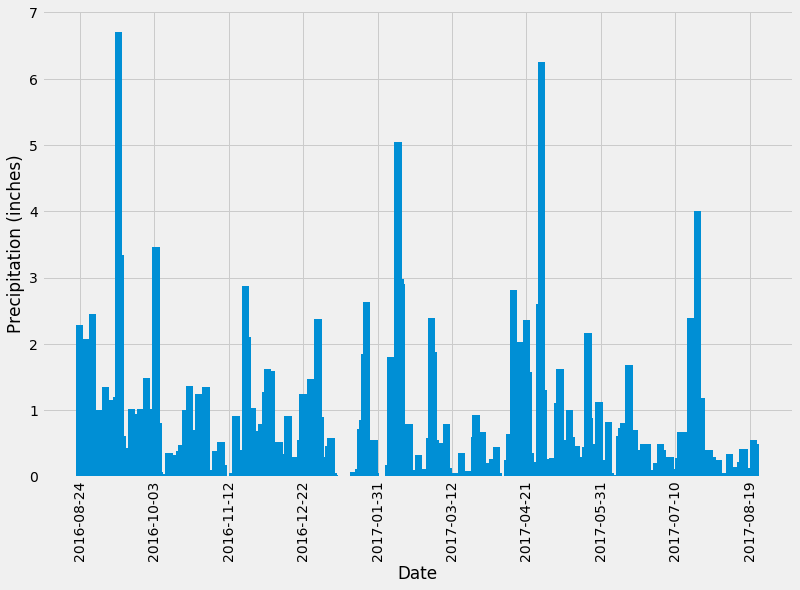

Text(0, 0.5, 'Precipitation (inches)')

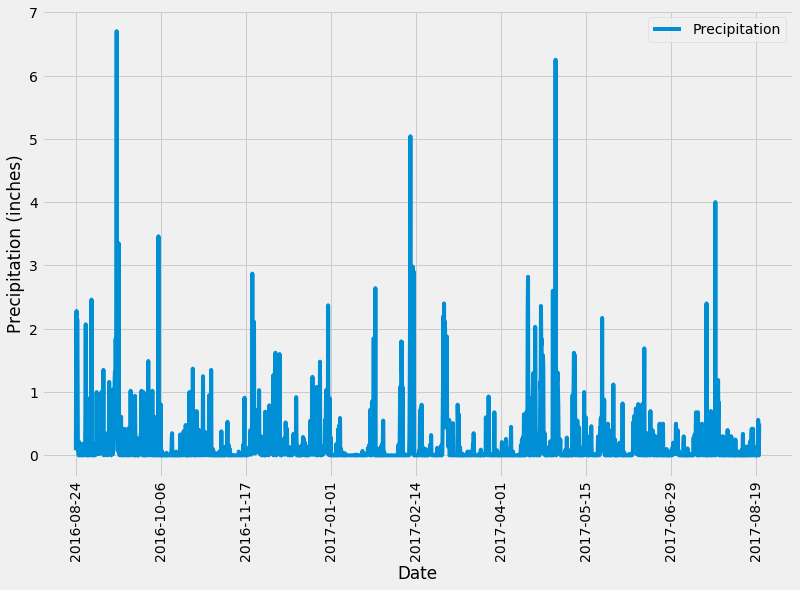

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Find the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# print(last_date)

# Extract the year, month, and day from the last date datapoint
last_date_year = last_date[0][0:4]
last_date_month = last_date[0][5:7]
last_date_day = last_date[0][8:10]
# print(last_date_year, last_date_month, last_date_day)

# Convert the last date information into a datetime object
last_date_dt = dt.date(int(last_date_year), int(last_date_month), int(last_date_day))
# print(last_date_dt)
                       
# Calculate the date 1 year ago from the last data point in the database
one_year_prior = last_date_dt - timedelta(days = 365)
# print(one_year_prior)

# Perform a query to retrieve the date and precipitation values. Filter by Measurement.date to capture the last 1 year of data points
precip_data_one_yr = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date < last_date_dt).filter(Measurement.date > one_year_prior).order_by(Measurement.date.asc()).all()
# data_one_yr[0]


# Save the query results as a Pandas DataFrame and set the index to the date column
# Initialize list for dates and precipitation values
date = []
precip = []

for datapoint in precip_data_one_yr:
    date.append(datapoint[0])
    precip.append(datapoint[1])
    
# print(date)
# print(precip)

# Create the Pandas dataframe
data_one_yr_df = pd.DataFrame({'Date':date, 'Precipitation':precip})
# Drop any rows with NAs
data_one_yr_df.dropna(axis = 0, how = 'any', inplace = True)
data_one_yr_df       


# # Note that the dataframe has already been pre-sorted due to the order_by method in the query call

# Set the date as the dataframe index
data_one_yr_df.set_index('Date', inplace = True)

# Create a list of dates from the dataframe index that can be used in the plot
dates_list = [date for date in data_one_yr_df.index]

# Plotting using Matplotlib

fig, ax = plt.subplots(1, 1, figsize = (12, 8))
ax.bar(dates_list, data_one_yr_df['Precipitation'], width = 4)
# The following line allows you to display only certain axis tick labels based on multiples of your choice
ax.xaxis.set_major_locator(MultipleLocator(40))
plt.xticks(rotation = 90)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
# ax.xaxis.set_major_formatter('{x:.0f}')
plt.show()

# Plotting using Pandas
ax = data_one_yr_df.plot(y = 'Precipitation', rot = 90, figsize = (12,8))
ax.set_ylabel('Precipitation (inches)')



In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary = data_one_yr_df.describe()
summary

,Precipitation
count,2011.000000
mean,0.176549
std,0.460667
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [13]:
# Design a query to show how many stations are available in this dataset?

# The .distinct() function can be used to generate a list of unique stations
num_stations = session.query(Measurement.station.distinct()).all()
# print(num_stations)
print(f'There are {len(num_stations)} stations in this dataset.')

# Alternatively one can perform a group_by to obtain a list of unique station tuples, then count the number of entries in that list
stations = session.query(Measurement.station).group_by(Measurement.station).all()
print(f'There are {len(stations)} stations in this dataset.')

There are 9 stations in this dataset.
There are 9 stations in this dataset.


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# To determine the stations in terms of activities, create a query that uses the func.count() method, groups the stations by station name, and orders them by the number of rows. 
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_activity

print(f"A list of stations by observations in descending order: \n {station_activity}.")
print("-------------")
print(f"The station with the highest number of observations is {station_activity[0][0]} with {station_activity[0][1]} total observations.")

A list of stations by observations in descending order: 
 [('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)].
-------------
The station with the highest number of observations is USC00519281 with 2772 total observations.


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


The maximum temperature recorded by station USC00519281 in the past year is 83.0.
The minimum temperature recorded by station USC00519281 in the past year is 59.0.
The average temperature recorded by station USC00519281 over the past year is 73.1.


Text(0, 0.5, 'Frequency')

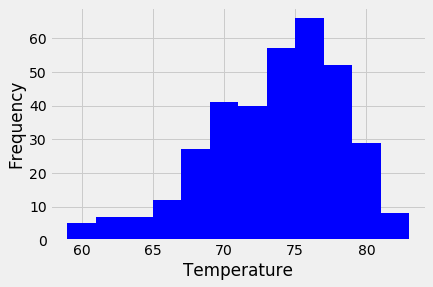

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Repurpose the query above with the same date filter, but this time add a filter for the most active station.
temp_station = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date > one_year_prior).all()

# Convert the list of temperature tuples into a list of temperature integers
temp_list = [temp[0] for temp in temp_station]

# Calculate the minimum, maximum, and average temperatures for this station
print(f'The maximum temperature recorded by station USC00519281 in the past year is {max(temp_list)}.')
print(f'The minimum temperature recorded by station USC00519281 in the past year is {min(temp_list)}.')
print(f'The average temperature recorded by station USC00519281 over the past year is {sum(temp_list)/len(temp_list):.01f}.')
      
# Plot the temperature histogram using matplotlib
plt.hist(temp_list, bins = 12, color = 'blue')
plt.xlabel("Temperature")
plt.ylabel("Frequency")

## Bonus Challenge Assignment

# Temperature Analysis I


An unpaired t-test is used here because the samples are independent. These are not repeat measurements, and the number of temperature measurments in June and December are not necessarily equal.


In [17]:
# Collect all dates and temperatures
all_dates_temps = session.query(Measurement.date, Measurement.tobs).order_by(Measurement.date.asc()).all()

# Initialize empty lists for June and December dates
june_temps = []
dec_temps = []

# Iterate through the query, saving June temperatures (month of 06) in june_temps and saving December temperaturs (month of 12) in dec_temps.
for item in all_dates_temps:
    if item[0][5:7] == '06':
        june_temps.append(item[1])
    elif item[0][5:7] =='12':
        dec_temps.append(item[1])

avg_june = sum(june_temps) / len(june_temps)
avg_dec = sum(dec_temps) / len(dec_temps)

# print(dec_temps)
print(f"The average temperature in Hawaii in June is {avg_june:.01f}")
print(f"The average temperature in Hawaii in December is {avg_dec:.01f}")

test_result = st.ttest_ind(june_temps, dec_temps)

print(f'The difference between the average temperature in Hawaii in June and December is significant, with a p-value of {test_result[1]}.')

The average temperature in Hawaii in June is 74.9
The average temperature in Hawaii in December is 71.0
The difference between the average temperature in Hawaii in June and December is significant, with a p-value of 3.9025129038616655e-191.


My vacation start date is December 18, 2016, with an end date of January 2, 2017. Data will be pulled from the previous years' matching dates.

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacation_temps = calc_temps('2015-12-18', '2016-01-02')


Text(0, 0.5, 'Temperature (F))')

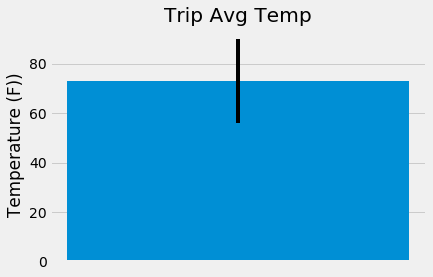

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
ax.bar(1,vacation_temps[0][1], width = 0.01, yerr = vacation_temps[0][2] - vacation_temps[0][0])
ax.xaxis.set_visible(False)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F))")


In [21]:
# Inspect the station table
inspector = inspect(engine)
columns_meas = inspector.get_columns('station')
for column in columns_meas:
    print(column['name'])

id
station
name
latitude
longitude
elevation


In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# This query will retrieve the desired station information while calculating the total rainfall for each station during the selected date ranges.
station_measurement_merged_vacation = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).filter(Measurement.station == Station.station).filter(Measurement.date >= '2015-12-18').filter(Measurement.date <= '2016-01-02').group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()


print(station_measurement_merged_vacation)

## Same thing, but with Pandas instead

# Read in CSVs
station_df = pd.read_csv('Resources/hawaii_stations.csv')
measurements_df = pd.read_csv('Resources/hawaii_measurements.csv')

# Merge CSVs on the station
merged_df = pd.merge(station_df, measurements_df, on = 'station')
# Filter by previous years' matching dates for vacation
vacation_dates_df = merged_df[(merged_df['date'] >= '2015-12-18') & (merged_df['date'] <= '2016-01-02')]

# Calculate total rainfall for each station for the duration of the trip dates
total_rainfall_per_station = vacation_dates_df.groupby(['station', 'name', 'latitude', 'longitude', 'elevation'])['prcp'].sum()
total_rainfall_per_station

# Sort the total rainfall for each station in descending order
total_rainfall_per_station_sorted = total_rainfall_per_station.sort_values(ascending = False)
total_rainfall_per_station_sorted

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 8.25), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 3.38), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.5799999999999996), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 1.4500000000000002), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.76), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.71), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.11)]


station      name                                    latitude  longitude   elevation
USC00516128  MANOA LYON ARBO 785.2, HI US            21.33310  -157.80250  152.4        8.25
USC00519281  WAIHEE 837.5, HI US                     21.45167  -157.84889  32.9         3.38
USC00513117  KANEOHE 838.1, HI US                    21.42340  -157.80150  14.6         2.58
USC00519523  WAIMANALO EXPERIMENTAL FARM, HI US      21.33556  -157.71139  19.5         1.45
USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US  21.52130  -157.83740  7.0          0.76
USC00519397  WAIKIKI 717.2, HI US                    21.27160  -157.81680  3.0          0.71
USC00517948  PEARL CITY, HI US                       21.39340  -157.97510  11.9         0.11
Name: prcp, dtype: float64

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2015-12-18'
end_date = '2016-01-02'
# Use the start and end date to create a range of dates
# Use pandas to do this
date_range = pd.date_range(start_date, end_date).tolist()


date_range_list = []
# for date in date_range:
#     print(str(date))

# Strip off the year and save a list of %m-%d strings
# Do this by converting each timestamp to a string, then slicing the MM-DD values out of it
mmdd_vacation = [str(date)[5:10] for date in date_range]

# Loop through the list of %m-%d strings and calculate the normals for each date. Push the tuples into the normals list
normals = []
for day in mmdd_vacation:
    normals.append(daily_normals(day))

# print(normals)
# Pull all of the tuple valuse into their own lists for plotting
tavg = [item[0][1] for item in normals]
tmin = [item[0][0] for item in normals]
tmax = [item[0][2] for item in normals]

In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df = pd.DataFrame({'Date': date_range, 'tmin' : tmin, 'tavg' : tavg, 'tmax' : tmax})
daily_normals_df.set_index('Date', inplace = True)
daily_normals_df

,tmin,tavg,tmax
Date,,,
2015-12-18,63.0,71.280000,77.0
2015-12-19,67.0,72.000000,78.0
2015-12-20,65.0,72.913043,81.0
2015-12-21,67.0,72.139535,78.0
2015-12-22,67.0,71.130435,77.0
2015-12-23,61.0,70.346939,78.0
2015-12-24,62.0,70.062500,78.0
2015-12-25,60.0,71.750000,79.0
2015-12-26,63.0,71.446809,77.0


Text(0, 0.5, 'Temperature (F)')

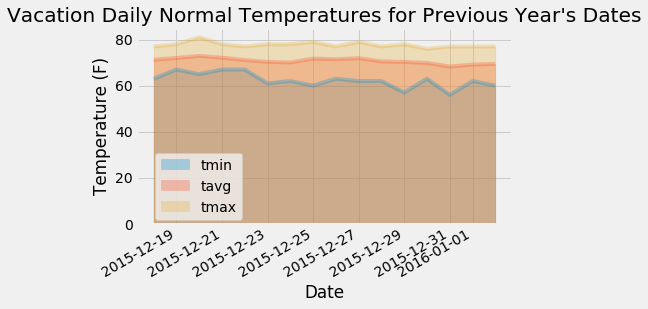

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
ax = daily_normals_df.plot.area(stacked = False, title = "Vacation Daily Normal Temperatures for Previous Year's Dates", x_compat = True, legend = 'True', alpha = 0.3)
ax.legend(loc = (0.05,0.02))

ax.set_ylabel('Temperature (F)')

